In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random

%matplotlib inline

In [3]:
N = 2
OUTPUT_SIZE = (50, 50)

UP = (0, -1)
DOWN = (0, 1)
LEFT = (-1, 0)
RIGHT = (1, 0)
UP_LEFT = (-1, -1)
UP_RIGHT = (1, -1)
DOWN_LEFT = (-1, 1)
DOWN_RIGHT = (1, 1)

dirs = [UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT]

In [4]:
def rotate(lst2D):
    return [[lst2D[j][i] for j in range(len(lst2D))] for i in range(len(lst2D[0])-1, -1, -1)]

def slice(lst2D, i, j, n):
    return list(map(lambda x: x[i:i+n], lst2D[j:j+n]))

In [5]:
class Pattern:
    def __init__(self, pixels):
        self.pixels = pixels
    
    def offsetTiles(self, direction):
        if direction == ( 0,  0):
            return self.pixels
        elif direction == (-1, -1):
            return self.pixels[0][0]
        elif direction == (-1,  0):
            return list(map(lambda x: x[0], self.pixels))
        elif direction == (-1,  1):
            return self.pixels[-1][0]
        elif direction == ( 0,  1):
            return self.pixels[-1]
        elif direction == ( 1,  1):
            return self.pixels[-1][-1]
        elif direction == ( 1,  0):
            return list(map(lambda x: x[-1], self.pixels))
        elif direction == ( 1, -1):
            return self.pixels[0][-1]
        elif direction == ( 0, -1):
            return self.pixels[0]
    
    def __eq__(self, other):
        return self.pixels == other.pixels
    
    def __hash__(self):
        return hash(tuple(map(lambda x: tuple(x), self.pixels)))

    def __repr__(self):
        return str(self.pixels)

In [6]:
class Index:
    def __init__(self, patterns):
        self.rules = {}
        for basePattern in patterns:
            self.rules[basePattern] = {}
            for d in dirs:
                self.rules[basePattern][d] = []
                for pattern in patterns:
                    if basePattern.offsetTiles(d) == pattern.offsetTiles((-d[0], -d[1])):
                        self.rules[basePattern][d].append(pattern)

    def check(self, basePattern, adjacentPattern, direction):
        return adjacentPattern in self.rules[basePattern][direction]

    def __repr__(self):
        string = ''
        for pattern in self.rules:
            string += f'{pattern}\n'
            for d in dirs:
                string += f'\t{d}\n'
                string += f'\t\t{self.rules[pattern][d]}\n'
            string += '\n'
        
        return string


In [7]:
class WaveFunction:
    def __init__(self, pixels, outputSize=OUTPUT_SIZE, n=N):
        self.inputSize = (len(pixels[0]), len(pixels))
        self.outputSize = outputSize
        
        patterns = []
        for i in range(self.inputSize[0]-n+1):
            for j in range(self.inputSize[1]-n+1):
                pattern = slice(pixels, i, j, n)                
                patterns.append(Pattern(pattern))
                patterns.append(Pattern(rotate(pattern)))
                patterns.append(Pattern(rotate(rotate(pattern))))
                patterns.append(Pattern(rotate(rotate(rotate(pattern)))))

                # mirror = list(map(lambda x: list(reversed(x)), pattern))
                # patterns.append(Pattern(mirror))
                # patterns.append(Pattern(rotate(mirror)))
                # patterns.append(Pattern(rotate(rotate(mirror))))
                # patterns.append(Pattern(rotate(rotate(rotate(mirror)))))
        
        self.patterns = list(set(patterns))
        self.weights = {p: patterns.count(p) for p in patterns}
        self.probabilities = {p: patterns.count(p) / len(patterns) for p in patterns}
        self.index = Index(self.patterns)
        self.coeffs = [[self.patterns for _ in range(outputSize[0])] for _ in range(outputSize[1])]
    
    def entropy(self, pos):
        x, y = pos

        if len(self.coeffs[y][x]) == 1:
            return 0
        
        return -sum([self.probabilities[p] * math.log(self.probabilities[p], 2) for p in self.coeffs[y][x]])
    
    def minEntropyPos(self):
        minEntropy = None
        pos = None

        for i in range(len(self.coeffs)):
            for j in range(len(self.coeffs[i])):
                entropy = self.entropy((j, i))

                if entropy != 0 and (minEntropy is None or minEntropy > entropy):
                    minEntropy = entropy
                    pos = j, i
        
        return pos
    
    def validDirs(self, pos):
        x, y = pos

        dirs = []
        if x == 0:
            dirs += [RIGHT]

            if y == 0:
                dirs += [DOWN, DOWN_RIGHT]
            elif y == self.outputSize[1] - 1:
                dirs += [UP, UP_RIGHT]
            else:
                dirs += [DOWN, DOWN_RIGHT, UP, UP_RIGHT]
        elif x == self.outputSize[0] - 1:
            dirs += [LEFT]

            if y == 0:
                dirs += [DOWN, DOWN_LEFT]
            elif y == self.outputSize[1] - 1:
                dirs += [UP, UP_LEFT]
            else:
                dirs += [DOWN, DOWN_LEFT, UP, UP_LEFT]
        else:
            dirs += [LEFT, RIGHT]

            if y == 0:
                dirs += [DOWN, DOWN_LEFT, DOWN_RIGHT]
            elif y == self.outputSize[1] - 1:
                dirs += [UP, UP_LEFT, UP_RIGHT]
            else:
                dirs += [DOWN, DOWN_LEFT, DOWN_RIGHT, UP, UP_LEFT, UP_RIGHT]

        return dirs
    
    def isCollapsed(self):
        for row in self.coeffs:
            for patterns in row:
                if len(patterns) > 1:
                    return False
        
        return True
    
    def patternsAtPos(self, pos):
        return self.coeffs[pos[1]][pos[0]]

    def observe(self):
        pos = self.minEntropyPos()

        if pos is None:
            return
        
        patterns = self.patternsAtPos(pos)
        
        # maxProbability = max([self.probabilities[p] for p in patterns])
        # self.coeffs[pos[1]][pos[0]] = [random.choice([p for p in patterns if self.probabilities[p] >= maxProbability-0.01])]
        # self.coeffs[pos[1]][pos[0]] = [random.choice(patterns)]
        self.coeffs[pos[1]][pos[0]] = random.choices(patterns, [self.probabilities[p] for p in patterns])
        
        return pos
    
    def propagate(self, pos):
        stack = [pos]

        while len(stack) > 0:
            pos = stack.pop()
            patterns = self.patternsAtPos(pos)    # it can be a list with only a single Pattern
            
            for d in self.validDirs(pos):
                adjacentPos = (pos[0]+d[0], pos[1]+d[1])
                adjacentPatterns = self.patternsAtPos(adjacentPos)

                availablePatterns = []
                for p in adjacentPatterns:
                    if any([self.index.check(basePattern, p, d) for basePattern in patterns]):
                        availablePatterns.append(p)
                
                if len(availablePatterns) > 0:
                    self.coeffs[adjacentPos[1]][adjacentPos[0]] = availablePatterns
                
                if len(availablePatterns) != len(adjacentPatterns):
                    stack.append(adjacentPos)
    
    def collapse(self):
        while not self.isCollapsed():
            pos = self.observe()
            self.propagate(pos)
        
        self.coeffs = [[patterns[0] for patterns in row] for row in self.coeffs]

    def imageFirsts(self):
        pixels = []
        for row in w.coeffs:
            r = []
            for pattern in row:
                r.append(pattern.pixels[0][0])
            pixels.append(r)
        
        return pixels
         
    def imagePatterns(self):
        pixels = []
        for row in self.coeffs:
            r = []
            for idx in range(N):
                level = []
                for pattern in row:
                    level += pattern.pixels[idx]
                r.append(level)
            pixels += r
        
        return pixels

In [8]:
pixels = [
            [ 255, 255, 255, 255 ],
            [ 255,   0,   0,   0 ],
            [ 255, 255, 255,   0 ],
            [ 255,   0,   0,   0 ]
         ]

w = WaveFunction(pixels)
w.collapse()

im1 = w.imageFirsts()

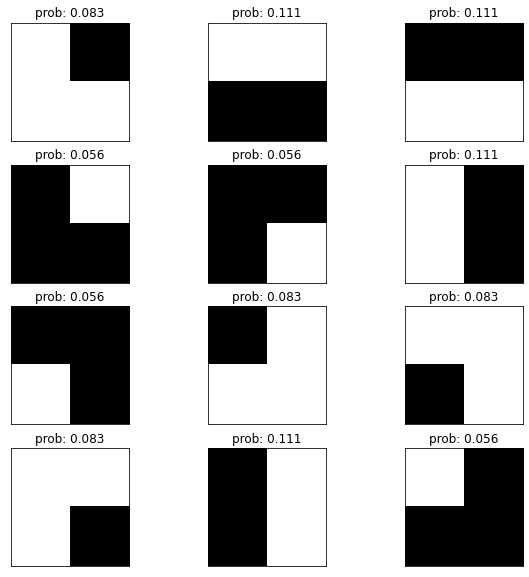

In [9]:
fig = plt.figure(figsize=(10, 10))

for i in range(len(w.patterns)):
    ax = plt.subplot(4, math.ceil(len(w.patterns)/4), i+1)
    ax.imshow(w.patterns[i].pixels, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f'prob: {round(w.probabilities[w.patterns[i]], 3)}')

plt.show()

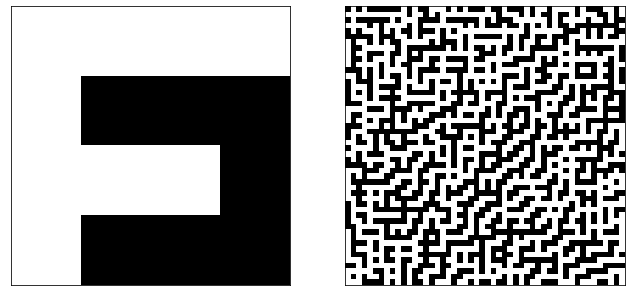

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 7))

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].imshow(pixels, cmap='gray', vmin=0, vmax=255)
ax[1].imshow(im1, cmap='gray', vmin=0, vmax=255)

plt.show()

In [11]:
class Queue:
    def __init__(self, q):
        self.queue = q
    

    # FIFO

    def get(self):
        return self.queue.pop(0)
    
    def put(self, element):
        self.queue.append(element)
    
    def clear(self):
        self.queue = []

    def __repr__(self):
        return str(self.queue)

In [12]:
WAYS = [UP, DOWN, LEFT, RIGHT]

In [13]:
class BFS:
    def __init__(self, maze):
        self.maze = maze

    def adjacentNodes(self, pos):
        x, y = pos
        valid = [255]

        nodes = []
        for dx, dy in WAYS:
            if 0 <= x+dx < len(self.maze[0]) and 0 <= y+dy < len(self.maze) and self.maze[y+dy][x+dx] in valid:
                nodes.append((x+dx, y+dy))
        
        return nodes
    
    def createGraph(self, start, finish):
        queue = Queue([start])
        
        graph = {start: None}

        while finish not in graph:
            pos = queue.get()

            for p in self.adjacentNodes(pos):
                if p not in graph:
                    graph[p] = pos
                    queue.put(p)
            
        return graph

    def path(self, start, finish):
        graph = self.createGraph(start, finish)

        currentPos = finish
        path = [start, finish]
        while currentPos != start:
            currentPos = graph[currentPos]
            path.insert(0, currentPos)
        
        return path
    
    def run(self, start, finish):
        path = self.path(start, finish)
        
        image = []
        for i in range(len(self.maze)):
            row = []
            for j in range(len(self.maze[i])):
                if (j, i) in path:
                    row.append(137)
                else:
                    row.append(self.maze[i][j])
            image.append(row)
            
        return image

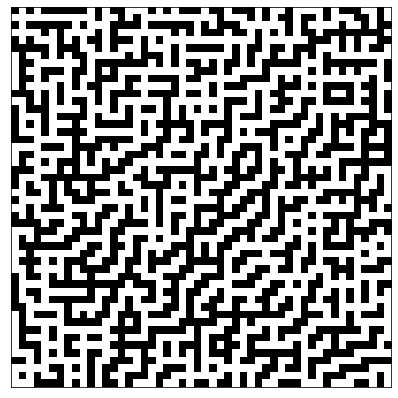

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

ax.set_xticks([])
ax.set_yticks([])

ax.imshow(im1, cmap='gray', vmin=0, vmax=255)

plt.show()

In [15]:
s1 = (42, 0)
f1 = (16, 49)

s2 = (42, 0)
f2 = (0, 12)

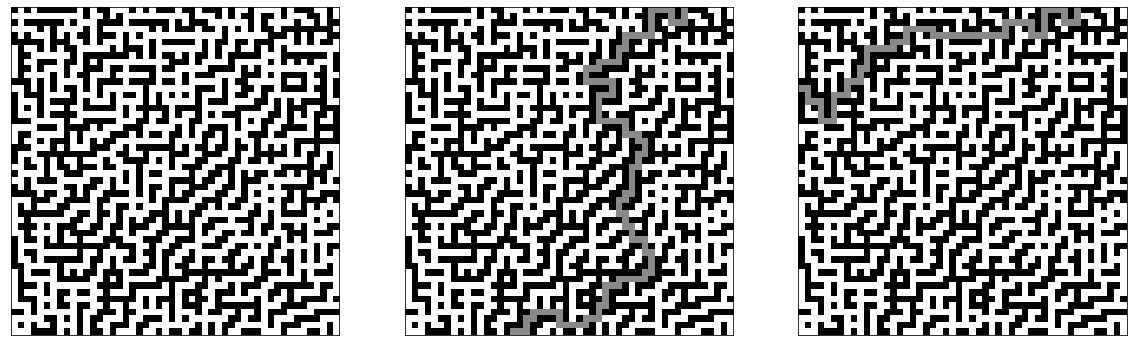

In [16]:
bfs = BFS(im1)
mazed1 = bfs.run(s1, f1)
mazed2 = bfs.run(s2, f2)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].imshow(im1, cmap='gray', vmin=0, vmax=255)
ax[1].imshow(mazed1, cmap='gray', vmin=0, vmax=255)
ax[2].imshow(mazed2, cmap='gray', vmin=0, vmax=255)

plt.show()